In [ ]:
!pip install pymedphys[user]==0.33.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymedphys

In [2]:
FIELD_TYPES = {
    0: "Unspecified",
    1: "Static",
    2: "StepNShoot",
    3: "Setup",
    4: "kV Setup",
    5: "CT",
    6: "Port",
    7: "Fixed",
    8: "Dynamic",
    9: "MV CT",
    11: "Arc",
    12: "Skip Arcs",
    13: "VMAT",
    14: "DMLC",
    15: "Helical",
    16: "Fixed Angle",
    17: "Path",
    18: "Shot",
    20: "User Defined",
    21: "PDR",
}

In [3]:
def get_patient_name(cursor, patient_id):
    patient_id = str(patient_id)

    patient_name_results = pymedphys.mosaiq.execute(
        cursor,
        """
        SELECT
            Patient.Last_Name,
            Patient.First_Name
        FROM Ident, Patient
        WHERE
            Patient.Pat_ID1 = Ident.Pat_ID1 AND
            Ident.IDA = %(patient_id)s
        """,
        {"patient_id": patient_id},
    )

    table = pd.DataFrame(data=patient_name_results, columns=["last_name", "first_name"])
    table.drop_duplicates(inplace=True)

    if len(table.index) < 1:
        raise ValueError("No patient found with that ID")

    if len(table.index) > 1:
        raise ValueError("Multiple patients were found with that ID")

    series = table.iloc[0]

    last_name = series["last_name"]
    first_name = series["first_name"]

    return last_name, first_name

In [4]:
def get_patient_fields(cursor, patient_id):
    """Returns all of the patient fields for a given Patient ID.
    """
    patient_id = str(patient_id)

    patient_field_results = pymedphys.mosaiq.execute(
        cursor,
        """
        SELECT
            TxField.FLD_ID,
            TxField.Field_Label,
            TxField.Field_Name,
            TxField.Version,
            TxField.Meterset,
            TxField.Type_Enum,
            Site.Site_Name
        FROM Ident, TxField, Site
        WHERE
            TxField.Pat_ID1 = Ident.Pat_ID1 AND
            TxField.SIT_Set_ID = Site.SIT_Set_ID AND
            Ident.IDA = %(patient_id)s
        """,
        {"patient_id": patient_id},
    )

    table = pd.DataFrame(
        data=patient_field_results,
        columns=[
            "field_id",
            "field_label",
            "field_name",
            "field_version",
            "monitor_units",
            "field_type",
            "site",
        ],
    )

    table.drop_duplicates(inplace=True)

    table["field_type"] = [FIELD_TYPES[item] for item in table["field_type"]]

    return table

In [5]:
mosaiq_hostname = 'msqsql'
patient_id = '979797'

In [6]:
with pymedphys.mosaiq.connect(mosaiq_hostname) as cursor:
    patient_name = get_patient_name(cursor, patient_id)
    fields = get_patient_fields(cursor, patient_id)

In [7]:
patient_name

('PHYSICS', 'TEST')

In [8]:
fields

,field_id,field_label,field_name,field_version,monitor_units,field_type,site
0,88064,1-1,VMAT,0,426.700,VMAT,VMAT


In [9]:
field_id = str(fields.field_id[0])
field_id

'88064'

In [10]:
with pymedphys.mosaiq.connect(mosaiq_hostname) as cursor:
    delivery = pymedphys.Delivery.from_mosaiq(cursor, field_id)

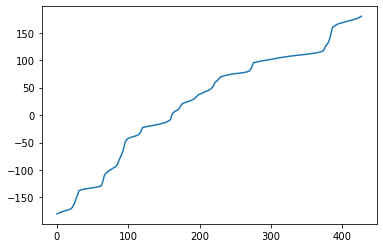

In [11]:
plt.plot(delivery.mu, delivery.gantry)

In [12]:
mu = np.array(delivery.mu)
mu.shape

(111,)

In [13]:
mlc = np.array(delivery.mlc)

In [14]:
mlc.shape

(111, 80, 2)

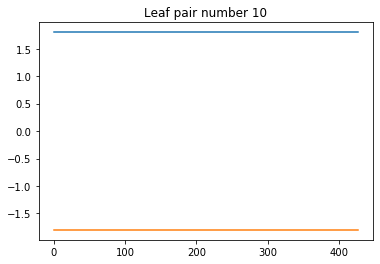

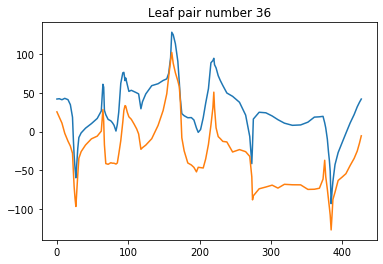

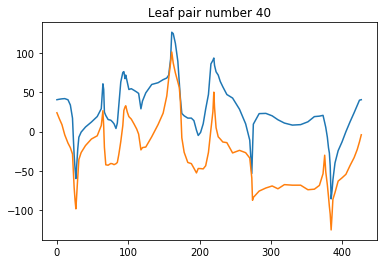

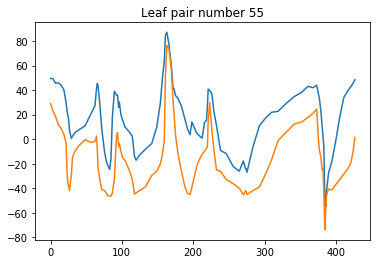

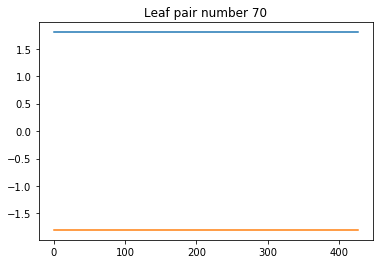

In [15]:
leaves_to_plot = [10, 36, 40, 55, 70]

for leaf_pair_number in leaves_to_plot:
    plt.figure()
    plt.title(f"Leaf pair number {leaf_pair_number}")
    plt.plot(mu, mlc[:,leaf_pair_number - 1, 0])
    plt.plot(mu, -mlc[:,leaf_pair_number - 1, 1])

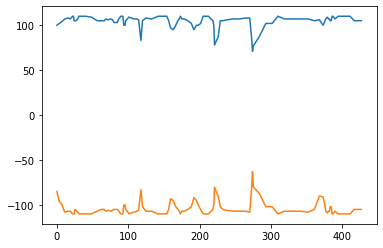

In [16]:
jaw = np.array(delivery.jaw)
plt.plot(mu, jaw[:,0])
plt.plot(mu, -jaw[:,1])

In [17]:
mudensity = delivery.mudensity()

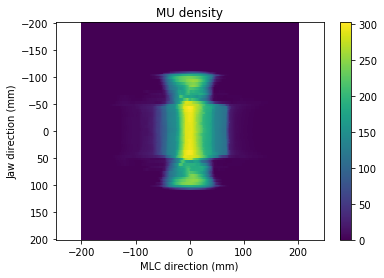

In [18]:
grid = pymedphys.mudensity.grid()
pymedphys.mudensity.display(grid, mudensity)